# Spectral fitting 
Demonstration of how to fit a spectrum for the example described in `response_demo.ipynb` where an instrument response was generated for a simple toy detector.

We will look at two different methods for comparison, both using [Stan](https://mc-stan.org).

In [1]:
import numpy as np
import h5py
import stan_utility
import corner
from matplotlib import pyplot as plt
from instrument_response.detector import Response

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We have some data detected by our toy detector. We think it comes from a power law (this is our model), and under this assumption, we want to fit for the normalisation, $N$, and spectral index, $\alpha$, of this model (the parameters). In order to compare our model with data, we will use the response generated in `response_demo.ipynb`.

In [2]:
# Load response
response_file = 'output/response_sim.h5'
with h5py.File(response_file, 'r') as f:
    initial_energy = f['initial_energy'].value
    true_energy = f['true_energy'].value
    detected_energy = f['detected_energy'].value
    effective_area_max = f['effective_area_maximum'].value
response = Response(initial_energy, true_energy, detected_energy, effective_area_max, 
                    nbins_true_energy=30, nbins_detected_energy=50)

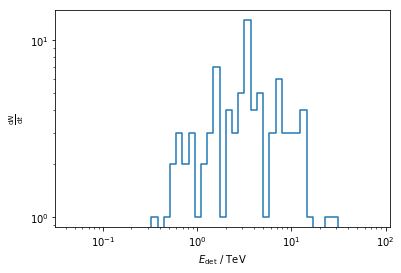

In [3]:
# Have a look at the data 
data_file = 'output/data.h5'

with h5py.File(data_file, 'r') as f:
    detected_energy = f['detected_energy'].value

dN_dt, _ = np.histogram(detected_energy, bins=response.detected_energy_bins)

fig, ax = plt.subplots()
ax.step(response.detected_energy_bins[:-1], dN_dt, where='pre')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{det}$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t}$');

## Standard approach
For this simple fitting example, we can fold our model spectrum through the instrument response to compare with the data in the fit, as described in `response_demo.ipynb`. We will use the Hamiltonian Monte Carlo approach implemented in `Stan` to determine which model parameters best describe our data.

The likelihood is:
$$
p(n | \alpha, N) = \prod_{i=1}^{N_{\rm{bins}}} \frac{s_i^{n_i}e^{-s_i}}{n_i!}
$$

where $s_i$ are the expected counts in each energy bin (or *channel*), computed by folding the model through the repsonse, and $n_i$ are the actual observed counts in each bin.

In [4]:
# Compile the Stan model
model = stan_utility.compile_model(filename='stan/standard_method.stan', 
                                   model_name='standard')

Using cached StanModel


In [6]:
# Run the fit
fit_input = {}
fit_input['Nbins_true'] = response.nbins_true_energy
fit_input['Nbins_detected'] = response.nbins_detected_energy
fit_input['min_energy'] = 1 # TeV
fit_input['max_energy'] = 100 # TeV
fit_input['n'] = dN_dt
fit_input['response_matrix'] = response.matrix
fit_input['true_energy_bins'] = response.true_energy_bins
fit_input['detected_energy_bins'] = response.detected_energy_bins

fit = model.sampling(data=fit_input, iter=1000, chains=4)

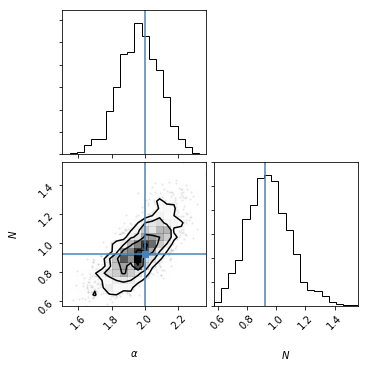

In [7]:
# View fit parameters
chain = fit.extract(permuted=True)
key_list = ['alpha', 'N']
labels = [r'$\alpha$', '$N$']
truths = [2.0, 0.9236320123663313]

corner.corner(np.column_stack([chain[key] for key in key_list]),
              labels=labels, truths=truths);

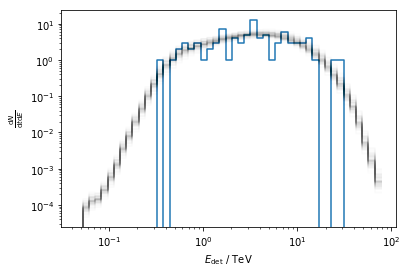

In [10]:
# Look at samples of folded model counts in data space
fig, ax = plt.subplots()
ax.step(response.detected_energy_bins[:-1], fit_input['n'], where='pre')
for i in range(100):
    ax.step(response.detected_energy_bins[:-1], chain['s'][i], 
            where='pre', color='k', alpha = 0.01)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{det}$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E}$');